# Meep to GDS

After designing and simulating a component using Meep, you can take that component and put it into GDS Factory. From there, you can design a circuit with it and put it into a GDS file. The method to do this is contained in `gdsfactory.simulation.gmeep.meep_adjoint_optimization` and is relatively straightforward. The function name is `get_component_from_sim`. It takes in a Meep simulation object (make sure it is 2D) and returns a GDS component. From there, you can use GDS Factory functions on it, or export it directly to a GDS file.

If you choose to continue manipulating the component in GDS Factory, you will most likely want to add ports to your component. This is done using the `add_ports` function for the component.

Example code for these functions is shown below.

boolean_883065f8: uid dded41fb, ports [], references [], 1 polygons


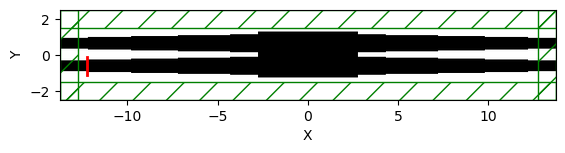

In [10]:
import meep as mp
from gdsfactory.simulation.gmeep.meep_adjoint_optimization import get_component_from_sim

Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)
wvl = 1.55
resolution = 20

# Variables for geometry
waveguide_width = 0.5
arm_separation = 0.25
mmi_length = 5.5
mmi_width = 2.5
taper_width = 1
taper_length = 10
pml_size = 1
pml_layers = [mp.PML(pml_size)]

Sx = 2 * taper_length + mmi_length + 2 * pml_size
Sy = mmi_width +  2 * pml_size + 0.5

taper_x1 = taper_length + mmi_length
taper_x2 = mmi_length / 2
taper_y1 = arm_separation / 2
taper_y2 = taper_width / 2 - waveguide_width / 2 + arm_separation / 2
taper_y3 = taper_width / 2 + waveguide_width / 2 + arm_separation / 2
taper_y4 = taper_width + arm_separation / 2

# Simulation geometry
geometry = [mp.Block(mp.Vector3(mmi_length, mmi_width), center=mp.Vector3(), material=Si),
               mp.Prism(vertices=[mp.Vector3(-taper_x2, -taper_y1), mp.Vector3(-taper_x2, -taper_y4), mp.Vector3(-taper_x1, -taper_y3), mp.Vector3(-taper_x1, -taper_y2)], height=mp.inf, material=Si),
               mp.Prism(vertices=[mp.Vector3(taper_x2, -taper_y1), mp.Vector3(taper_x2, -taper_y4), mp.Vector3(taper_x1, -taper_y3), mp.Vector3(taper_x1, -taper_y2)], height=mp.inf, material=Si),
               mp.Prism(vertices=[mp.Vector3(-taper_x2, taper_y1), mp.Vector3(-taper_x2, taper_y4), mp.Vector3(-taper_x1, taper_y3), mp.Vector3(-taper_x1, taper_y2)], height=mp.inf, material=Si),
               mp.Prism(vertices=[mp.Vector3(taper_x2, taper_y1), mp.Vector3(taper_x2, taper_y4), mp.Vector3(taper_x1, taper_y3), mp.Vector3(taper_x1, taper_y2)], height=mp.inf, material=Si),
]

# Variables for the source
fcen = 1 / wvl
width = 0.2
fwidth = width * fcen
source_center_x = -(mmi_length / 2 + taper_length - 0.5)
source_size = mp.Vector3(0, waveguide_width + 0.5)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)

sources = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint = kpoint,
        size=source_size,
        center=mp.Vector3(source_center_x, -(taper_y2 + waveguide_width / 2)),
    ),
]

sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    default_material=SiO2,
    resolution=resolution,
    geometry_center = mp.Vector3()
)

# Visualize the simulation
sim.plot2D()

# Specify simulation and center frequency of source to get component
mmi = get_component_from_sim(sim, fcen)
# Can specify a different location to save file
mmi.write_gds(gdspath="2x2MMI.gds")

# Specify a list of ports and use the following function to add ports to your component
# mmi.add_ports(ports=[list of ports])